Goal: we want to approximate the dominant eigenfunctions of the transfer operator underlying some observed dynamics.

To do this, we need to choose a good basis set. The variational principle of molecular kinetics lets us choose the optimal linear combinations of a given set of basis functions. In MSMs, these basis functions are indicator functions on a partitioning of the configuration space. In tICA, these basis functions are arbitrary input variables, usually internal coordinates like dihedral angles.

Another approach to constructing a basis set is to measure RMSD or weighted RMSD to some reference structures. A major benefit of that approach is that the model should now be differentiable with respect to the parameters defining the basis functions-- the locations of the references, and their associated weights and scale parameters.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import mdtraj
plt.rc('font', family='serif')

In [2]:
# fetch example data

from msmbuilder.example_datasets import FsPeptide
dataset = FsPeptide().get()
fs_trajectories = dataset.trajectories
fs_t = fs_trajectories[0]

loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


In [3]:
# 1. internal coordinate basis sets

from msmbuilder.featurizer import DihedralFeaturizer

basis_sets = dict()

dih_model=DihedralFeaturizer()
X = dih_model.fit_transform(fs_trajectories)
basis_sets['dihedral_phi_psi'] = X

dih_model=DihedralFeaturizer(types=['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4'])
X = dih_model.fit_transform(fs_trajectories)
basis_sets['dihedral_all'] = X

In [4]:
# 2. RMSD to reg-space refs
references = [x[::4000] for x in fs_trajectories]
refs = references[0]
for ref in references[1:]:
    refs = refs + ref


# oh, this is already built into MSMBuilder
#def compute_rmsds_to_refs(trajectories,refs):
#    basis_exps = []
#    for traj in trajectories:
#        rmsd_to_refs = np.zeros((len(traj),len(refs)))
#        for i in range(len(refs)):
#            rmsd_to_refs[:,i] = mdtraj.rmsd(traj,refs,i)
#        basis_exps.append(rmsd_to_refs)
#    return basis_exps
    
#basis_sets['rmsd_reg'] = compute_rmsds_to_refs(fs_trajectories,refs)

from msmbuilder.featurizer import RMSDFeaturizer
rmsdf = RMSDFeaturizer(refs)
basis_sets['rmsd_reg'] = rmsdf.fit_transform(fs_trajectories)

print(len(refs))

84


In [5]:
# 3. RMSD to cluster-center refs

# pick cluster centers by k-medoids
from msmbuilder.cluster import MiniBatchKMedoids
kmed = MiniBatchKMedoids(50,batch_size=200)
kmed.fit(X)

MiniBatchKMedoids(batch_size=200, max_iter=5, max_no_improvement=10,
         metric='euclidean', n_clusters=50, random_state=None)

In [59]:
# extract examplar configurations
clever_refs = []
for ind in kmed.cluster_ids_:
    clever_refs.append(fs_trajectories[ind[0]][ind[1]])

# convert list of length-1 mdtraj Trajectories to a single trajectory
# -- currently doing this in the most inefficient way possible, but it's 
# a tiny list so it doesn't matter
clever_ref = clever_refs[0]
for i in range(1,len(clever_refs)):
    clever_ref = clever_ref + clever_refs[i]
clever_refs = clever_ref
print(len(clever_refs))

50


In [61]:
basis_sets['rmsd_kmed'] = compute_rmsds_to_refs(fs_trajectories,clever_refs)

In [26]:
# 4. wRMSD to reg-space refs

from MDAnalysis.analysis.rms import rmsd as wRMSD

# compute weights from atomwise deviations
atomwise_deviations = np.load('fs_atomwise_deviations_tau=20.npy')
mean = atomwise_deviations.mean(0)
weights = np.exp(-mean/0.065)

In [84]:
def compute_wrmsd_traj(trajectories,refs,weights):
    ''' compute wRMSDs from trajectories to a list of references'''
    
    basis_exps = []
    for traj in trajectories:
        wrmsd_to_refs = np.zeros((len(traj),len(refs)))
        for i in range(len(traj)):
            for j in range(len(refs)):
                wrmsd_to_refs[i,j] = wRMSD(refs.xyz[j],traj.xyz[i],weights=weights,center='True')
        basis_exps.append(wrmsd_to_refs)
    return basis_exps

weighted_trajs = compute_wrmsd_traj(fs_trajectories,refs,weights)
basis_sets['wrmsd_exp'] = weighted_trajs

In [77]:
np.save('wrmsd_exp.npy',weighted_trajs)
#np.save('wrmsd_inv.npy',inv_mean_weighted_trajs)
#np.save('wrmsd_mean.npy',mean_weighted_trajs)

In [8]:
# loading from file
weighted_trajs = np.load('wrmsd_exp.npy')
weighted_trajs.shape # 28 trajectories, 10k frames / traj, 84 basis fxns

(28, 10000, 84)

In [36]:
# grid search over alphas, assuming the same alpha for all 

alphas = np.logspace(-10,10,base=np.e)

for i,alpha in enumerate(alphas):
    basis_sets['wrmsd_gauss_{0}'.format(i)] = np.exp(-(weighted_trajs)**2 / (alpha*np.ones(84)))

In [43]:
rmsd_basis = np.array(basis_sets['rmsd_reg'])

In [44]:
for i,alpha in enumerate(alphas):
    basis_sets['rmsd_gauss_{0}'.format(i)] = np.exp(-(rmsd_basis)**2 / (alpha*np.ones(84)))

In [37]:
alphas[18]

0.070435264538866088

In [161]:
# 5. indicator functions
clusters = kmed.transform(X)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(n_values=np.max(np.vstack(clusters))+1,
                    sparse=False)
cluster_enc = enc.fit_transform(clusters[0].reshape((len(clusters[0]),1)))

In [163]:
from msmbuilder.msm import MarkovStateModel
msm = MarkovStateModel()
msm.fit(clusters)
msm.score_

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%


9.198693045227742

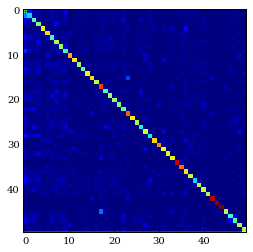

In [165]:
plt.imshow(msm.transmat_,interpolation='none')

In [26]:
from msmbuilder.decomposition import tICA

def score_via_tica(basis_set,m=10,lag_time=100):
    ''' Since the optimal matrix of expansion coefficients A is given by
    concatenating the generalized eigenvectors of the overlap and time-lagged overlap
    matrices, we can directly measure the quality of a candidate basis set for rank-m
    transfer operator approximation by performing tICA, then summing the top m eigenvalues.
    '''
    tica = tICA(lag_time=lag_time)
    tica.fit(basis_set)
    return np.sum(tica.eigenvalues_[:m])

def score_via_gmrq(basis_set,expansion_coeffs=None,m=10,lag_time=100):
    
    ### WARNING: this is buggy-- this *should* give the same answer as tICA
    # if you pass it the same basis_set and don't specify expansion_coeffs
    # but the answer's off by ~10% on examples.
    # I'm also not handling singular matrices correctly I think.
    tau = lag_time
    
    # compute the overlap and time-lagged overlap matrices
    S = basis_set.T.dot(basis_set) / len(basis_set)
    C = basis_set[tau:].T.dot(basis_set[:-tau]) / len(basis_set - tau)
    
    # expansion coefficients
    if expansion_coeffs == None:
        import scipy.linalg as la
        eig_vals,eig_vecs = la.eig(C,S)

        # discard imaginary component
        eig_vals = np.array(eig_vals,dtype=float)
        eig_vecs = np.array(eig_vecs,dtype=float)
        
        A = eig_vecs[:,:m]
        #A = np.diag(np.ones(basis_set.shape[1]))
    else:
        A = expansion_coeffs
    
    # compute the GMRQ from these overlap matrices
    P = A.T.dot(C).dot(A)
    Q = A.T.dot(S).dot(A)
    try:
        Q_inv = np.linalg.inv(Q)
    except:
        # it could be singular
        Q_inv = np.linalg.pinv(Q)
    P_Q_inv = P.dot(Q_inv)
    diag = np.sort(np.diag(P_Q_inv))[::-1]
    partial_trace = diag[:m]
    return P_Q_inv,np.sum(partial_trace)

In [27]:
score = score_via_tica

In [156]:
# actually, I might need to make a small modification to GMRQ to accept
# direct eigenfunction approximations that 

In [157]:
P_Q_inv,gmrq = score_via_gmrq(weighted_trajs[0])
P_Q_inv.shape,gmrq

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


((10, 10), 5.4342322949377522)

In [159]:
# these should be equal: indicates a problem
gmrq,score_via_tica([weighted_trajs[0]])

(5.4342322949377522, 6.0719085133573349)

In [45]:
scores = dict()
for name in basis_sets:
    scores[name] = score(basis_sets[name],m=20,lag_time=100)

In [46]:
sorted(scores.items(),key=lambda item:-item[1])

[('dihedral_all', 17.84744612314757),
 ('dihedral_phi_psi', 17.706953927713055),
 ('rmsd_gauss_19', 16.115931213836159),
 ('wrmsd_gauss_18', 15.867563082810944),
 ('rmsd_gauss_20', 15.749269619316632),
 ('rmsd_gauss_18', 15.713492655475971),
 ('wrmsd_gauss_17', 15.660209846734993),
 ('wrmsd_gauss_19', 15.574365762409482),
 ('rmsd_gauss_21', 15.01726793822754),
 ('wrmsd_gauss_16', 14.954281225788989),
 ('wrmsd_gauss_20', 14.92095943065088),
 ('rmsd_gauss_17', 14.614756841721887),
 ('wrmsd_gauss_21', 14.24894879943651),
 ('rmsd_gauss_22', 14.244254350190033),
 ('wrmsd_gauss_15', 13.857112461769063),
 ('wrmsd_gauss_22', 13.728515930356821),
 ('rmsd_gauss_23', 13.586667712331593),
 ('wrmsd_gauss_23', 13.374535293414604),
 ('wrmsd_gauss_24', 13.152734462661316),
 ('rmsd_reg', 13.109391912745712),
 ('rmsd_gauss_24', 13.099652108436416),
 ('wrmsd_gauss_25', 13.025641509847539),
 ('wrmsd_gauss_26', 12.950856083238415),
 ('wrmsd_gauss_27', 12.905145867822972),
 ('wrmsd_gauss_28', 12.87648933502

In [89]:
# 'archive'
scores.items()

[('dihedral_all', 17.84744612314757),
 ('rmsd', 13.109391916360241),
 ('dihedral_phi_psi', 17.706953927713055),
 ('rmsd_kmed', 9.0194490101577163),
 ('wrmsd_exp', 13.541230898294337),
 ('rmsd_reg', 13.109391916392024)]